<font color=red>注：此处是文档第76页</font>

## PyTorch之迁移学习

实际中，基本没有人会从零开始（随机初始化）训练一个完整的卷积网络，因为相对于网络，很难得到一个足够大的数据集（网络很深, 需要足够大数据集）。通常的做法是在一个很大的数据集上进行预训练得到卷积网络ConvNet, 然后将这个ConvNet的参数作为目标任务的初始化参数或者固定这些参数。

转移学习的两个主要场景：
- 微调**Convnet**：使用预训练的网络(如在 imagenet 1000 上训练而来的网络)来初始化自己的网络，而不是随机初始化。其他的训练步骤不变。
- 将**Convnet**看成固定的特征提取器:首先固定ConvNet除了最后的全连接层外的其他所有层。最后的全连接层被替换成一个新的随机初始化的层，只有这个新的层会被训练（只有这层参数会在反向传播时更新）

下面是利用PyTorch进行迁移学习步骤，要解决的问题是训练一个模型来对蚂蚁和蜜蜂进行分类。

**迁移学习**：用一个训练好的模型，更换数据，训练一个新的模型。

### 1.导入相关的包

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

### 2.加载数据
今天要解决的问题是训练一个模型来分类蚂蚁ants和蜜蜂bees。ants和bees各有约120张训练图片。每个类有75张验证图片。从零开始在 如此小的数据集上进行训练通常是很难泛化的。由于我们使用迁移学习，模型的泛化能力会相当好。 该数据集是imagenet的一个非常小的子集。从[此处](https://download.pytorch.org/tutorial/hymenoptera_data.zip)下载数据，并将其解压缩到当前目录。


In [2]:
# 训练集数据扩充和归一化
# 在验证集上仅需要归一化
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 数据标准化
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 数据标准化
    ])
}

data_dir = '../../data/hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_size = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda: 0' if torch.cuda.is_available() else 'cpu')

### 3.可视化部分图像数据
可视化部分训练图像，以便了解数据扩充

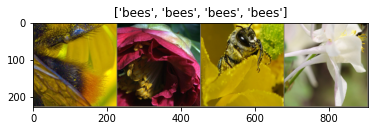

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated(暂停一下，以便更新图)
    
    
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 4.训练模型
编写一个通用函数来训练模型。下面将说明： **调整学习速率** 保存最好的模型

下面的参数scheduler是一个来自 `torch.optim.lr_scheduler` 的学习速率调整类的对象(LR scheduler object(LR调度程序对象))。

源代码执行时出现警告：  
<font color='red'>UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate<br/>
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)</font>

认为是`optimizer.step()`在`lr_scheduler.step()`前面了，因此在该代码中改正。（估计是版本更新的问题）

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    param: model: 要训练的网络模型
    param: criterion: 损失函数
    param: optimizer: 优化器，梯度下降等
    param: scheduler: 步长，采用lr_scheduler下的步长类实例化可以根据需要动态更新步长
    param: num_epochs: 迭代次数
    return: model
    """
    since = time.time()  # 计算模型运行时间
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 每个epoch都有一个训练和验证阶段
        for phase in ['train', 'val']:
            # 解释在笔记
            if phase == 'train':
                # scheduler.step()  # 提示应该在optimizer.step()之后，因此挪了位置
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            # 迭代数据.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 参数梯度清零
                optimizer.zero_grad()
                
                # 前向
                # track history if only in train  # 在测试集上可以追寻历史
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # 后向+仅在训练阶段进行优化
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                if phase == "train":
                    scheduler.step()
                # 统计
                running_loss += loss.item() * inputs.size(0)  #  总损失
                running_corrects += torch.sum(preds == labels.data)  # 正确分类的数量
            
            epoch_loss = running_loss / dataset_size[phase]  # 均方差
            epoch_acc = running_corrects.double() / dataset_size[phase]  # 正确率
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            # 如果当前模型优于上一轮迭代，更新模型参数，与正确率
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

### 5.可视化模型的预测结果

In [18]:
#一个通用的展示少量预测图片的函数
def visualize_model(model, num_images=6):
    """
    param: modle: 训练好的模型
    param: num_images: 要展示的图片数量
    """
    was_training = model.training  # 用来表示是不是在 training 状态下
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 6.场景1：微调ConvNet
加载预训练模型并重置最终完全连接的图层。

Downloading: "[https://download.pytorch.org/models/resnet18-5c106cde.pth](https://download.pytorch.org/models/resnet18-5c106cde.pth)" to C:\Users\oscar/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 观察所有参数都正在优化
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7个epochs衰减LR通过设置gamma=0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

**训练和评估模型**


（1）训练模型该过程在CPU上需要大约15-25分钟，但是在GPU上，它只需不到一分钟。

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5135 Acc: 0.7418
val Loss: 0.2014 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.6095 Acc: 0.7295
val Loss: 0.3368 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.5180 Acc: 0.7746
val Loss: 0.5868 Acc: 0.7974

Epoch 3/24
----------
train Loss: 0.6905 Acc: 0.7664
val Loss: 0.9401 Acc: 0.7516

Epoch 4/24
----------
train Loss: 0.9057 Acc: 0.6967
val Loss: 0.3419 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4333 Acc: 0.8197
val Loss: 0.3142 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.3903 Acc: 0.8320
val Loss: 0.2111 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3231 Acc: 0.8934
val Loss: 0.1828 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2286 Acc: 0.9262
val Loss: 0.2004 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2684 Acc: 0.8893
val Loss: 0.1775 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3802 Acc: 0.8730
val Loss: 0.1789 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.4377 Acc: 0.8156
val Loss: 0.1695 Acc: 0.9346

Ep

（2）模型评估效果可视化

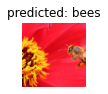

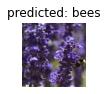

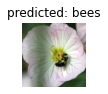

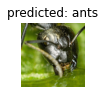

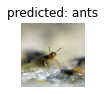

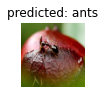

In [19]:
visualize_model(model_ft)

### 7.场景2：ConvNet作为固定特征提取器
在这里需要冻结除最后一层之外的所有网络。通过设置 `requires_grad == Falsebackward()` 来冻结参数，这样在反向传播backward()的时候他们的梯度就不会被计算。

In [20]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
#新构建模块的参数默认为requires_grad=True
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
# 观察到只有最后一层的参数被优化，而不是以前。
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

**训练和评估**

（1）训练模型在CPU上，与前一个场景相比，这将花费大约一半的时间，因为不需要为大多数网络计算梯度。但需要计算转发。

In [21]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


D:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5889 Acc: 0.6967
val Loss: 0.2095 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4495 Acc: 0.7951
val Loss: 0.1778 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.5345 Acc: 0.7787
val Loss: 0.1877 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4506 Acc: 0.7746
val Loss: 0.3059 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.7651 Acc: 0.7377
val Loss: 0.1605 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5565 Acc: 0.7951
val Loss: 0.1537 Acc: 0.9608

Epoch 6/24
----------
train Loss: 0.3033 Acc: 0.8730
val Loss: 0.1876 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3627 Acc: 0.8566
val Loss: 0.1798 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2902 Acc: 0.8852
val Loss: 0.1437 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.3972 Acc: 0.8279
val Loss: 0.1657 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4730 Acc: 0.7992
val Loss: 0.2279 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3635 Acc: 0.8402
val Loss: 0.1691 Acc: 0.9608

Epoch 12/24
----------
t

（2）模型评估效果可视化

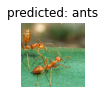

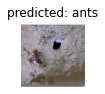

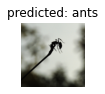

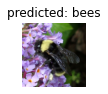

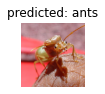

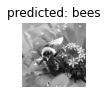

In [22]:
visualize_model(model_conv)

plt.ioff()
plt.show()